# Lecture 21 – Data 100, Spring 2022

by Lisa Yan

Adapted from Josh Hug, Joey Gonzalez, Ani Adhikari, Suraj Rampure

This notebook accompanies the lecture on Logistic Regression and was updated to incorporate the new video-notebook format. If you have not already watched the accompanying lecture, you should do that first. 

In this notebook we walk through the (miss)application of least-squares regression to a binary classification task.  In the process, we will show why a different model and loss is needed.  We will then demonstrate how to use the scikit-learn logistic regression model. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [2]:
# formatting options

# big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size
    plt.rcParams['font.size'] = SMALL_SIZE
    plt.rcParams['axes.titlesize'] = SMALL_SIZE
    plt.rcParams['axes.labelsize'] = MEDIUM_SIZE
    plt.rcParams['xtick.labelsize'] = SMALL_SIZE
    plt.rcParams['ytick.labelsize'] = SMALL_SIZE
    plt.rcParams['legend.fontsize'] = SMALL_SIZE
    plt.rcParams['figure.titlesize'] = BIGGER_SIZE
    # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    # plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    # plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    # plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    # plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
def savefig(fname):
    if not os.path.exists("images"):
        os.mkdir("images")
    fig = plt.gcf()
    fig.patch.set_alpha(0.0)
    plt.savefig(f"images/{fname}.png", bbox_inches = 'tight');
    
    
# plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
#sns.set()
adjust_fontsize(20)


---

## (Notebook setup) Obtaining the Data

For this lecture, we will use the Wisconsin Breast Cancer Dataset which we can obtain from [scikit learn](http://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-database). 

This dataset consists of measurements from tumor biopsies for 569 patients as well as whether the tumor was malignant or benign.

In [3]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
data = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### The Prediction Task

The prediction task for this data is to predict whether a tumor is benign or malignant (a binary decision) given characteristics of that tumor. As a classic machine learning dataset, the prediction task is captured by the column named `"target"`.  To put the data back in it's original context we will create a new column called `"malignant"` which will be 1 if the tumor is malignant and 0 if it is benign (reversing the definition of target).  

In [4]:
# Target data_dict['target'] = 0 is malignant 1 is benign
data['malignant'] = (data_dict['target'] == 0).astype(int)

### Selecting Features

What features might be a good indication of whether a tumor is benign or malignant? 

In [5]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'malignant'],
      dtype='object')

In [6]:
data[['mean radius', 'malignant']]

,mean radius,malignant
0,17.99,1
1,20.57,1
2,19.69,1
3,11.42,1
4,20.29,1
...,...,...
564,21.56,1
565,20.13,1
566,16.60,1
567,20.60,1


Perhaps a good starting point is the size of the tumor.  Larger tumors are probably more likely to be malignant.  In the following, we plot whether the tumor was malignant (1 or 0) against the `"mean radius"`.

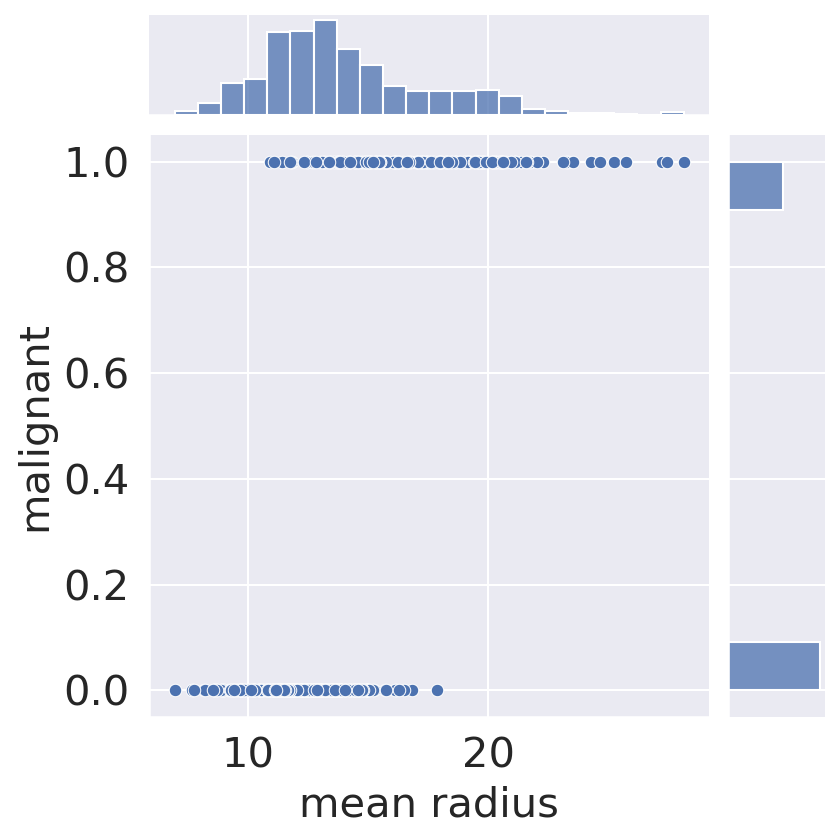

In [7]:
sns.jointplot(data = data, x = "mean radius", y = "malignant");
#savefig("overplot")

This is a clear example of over-plotting.  We can improve the above plot by jittering the data:

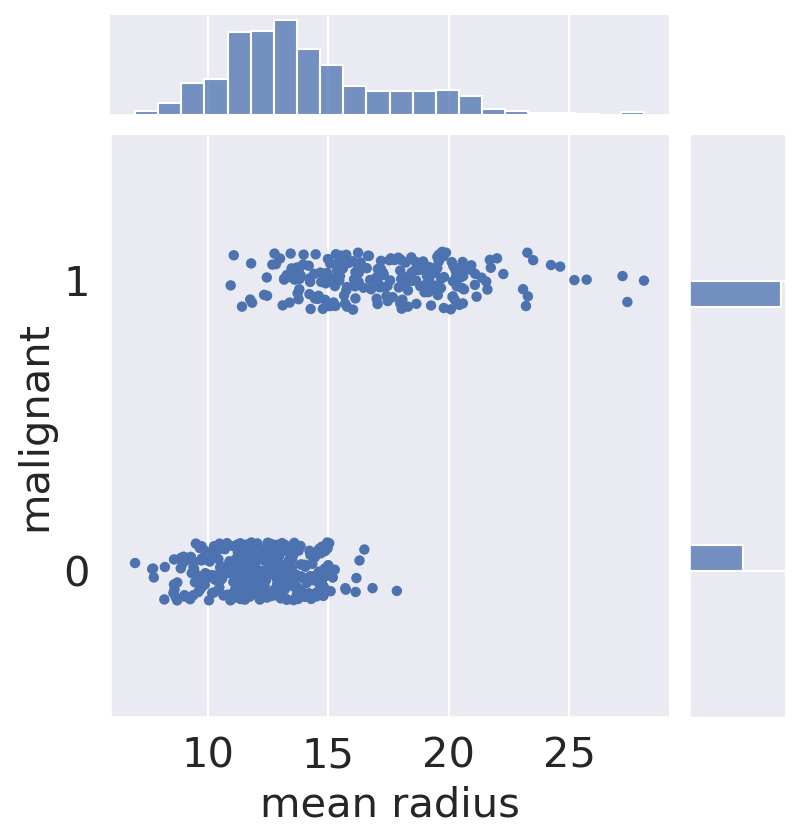

In [8]:
# manual to allow for jitter
g = sns.JointGrid(data = data, x = "mean radius", y = "malignant")
g.plot_marginals(sns.histplot)
g.plot_joint(sns.stripplot,
             orient='h', order=[1, 0],
             color=sns.color_palette()[0])
(g.ax_joint).set_xticks([10, 15, 20, 25])
savefig("jitter")
plt.show()

Perhaps a better way to visualize the data is using stacked histograms.

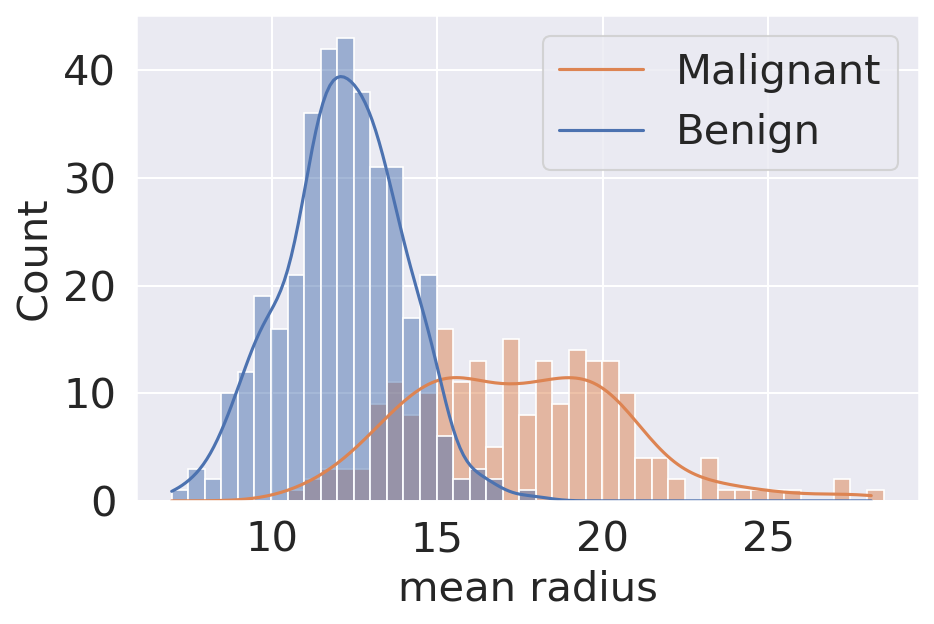

In [9]:
sns.histplot(data = data, x = "mean radius", hue = "malignant",
             binwidth=0.5,
             kde=True);
plt.legend(labels=["Malignant", "Benign"])

**Question:** Looking at the above histograms could you describe a rule to predict whether or a cell is malignant?


### Preparing the Data Train-Test Split

Always split your data into training and test groups.  

In [10]:
from sklearn.model_selection import train_test_split
data_tr, data_te = train_test_split(data, test_size=0.10, random_state=42)
data_tr.reset_index(inplace=True, drop=True)
data_te.reset_index(inplace=True, drop=True)
print("Training Data Size: ", len(data_tr))
print("Test Data Size: ", len(data_te))

Training Data Size:  512
Test Data Size:  57


Creating the `X` and `Y` matrices for the training data:

In [11]:
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()

---

<br/><br/><br/><br/><br/><br/><br/>


# Why Not Use Least-Squares Linear Regression?

_"I suppose it is tempting, if the only tool you have is a hammer, to treat everything as if it were a nail."_ -  Abraham Maslow The Psychology of Science

We would like to predict whether the tumor is malignant from the size of the tumor.  We have encoded whether a tumor is malignant or benign as 1 or 0.  Those are numbers that we could pretend are continuous and directly apply least squares regression.  Why not start there?

In the following, we use Seaborn's simple linear regression fit. Note, we will not use any regularization since this is a really simple one-dimensional model with a comparatively large training dataset. 

How well does our model fit the data?

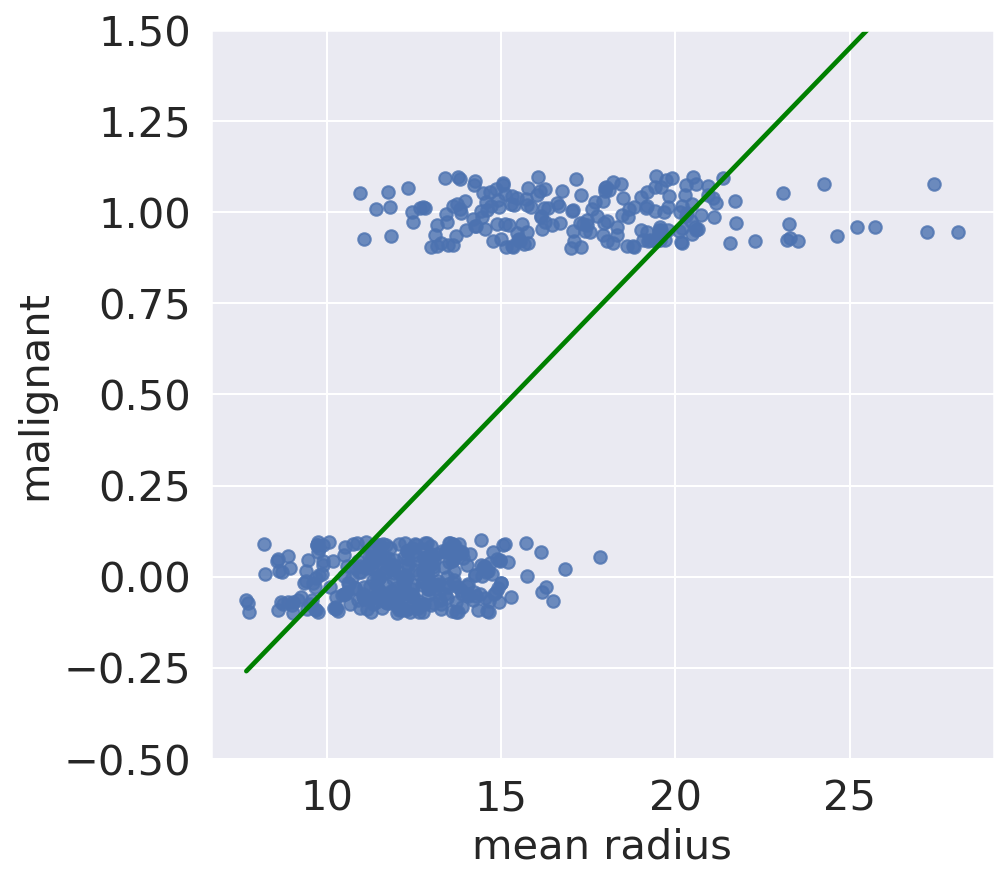

In [12]:
plt.figure(figsize=(6, 6))
sns.regplot(data=data_tr, x='mean radius', y='malignant', 
              y_jitter = 0.1, 
              ci=False,
              line_kws={'color':'green'});
plt.ylim((-0.5, 1.5))
savefig("least_squares")

<br/><br/>

Among various issues (such as the fit being hard to interpret), the OLS model is very sensitive to outliers.

Suppose we had a training datapoint with extra-large $x$. See how least squares linear regression overfits to the large outlier point. It completely changes the classification for a large set of our datapoints.

In [13]:
data_out = data_tr[['mean radius', 'malignant']].copy()

# replace a datapont with a big outlier
# (mean radius = 120, malignant = 1) 
data_out.iloc[0, :2] = [120, 1]
data_out.head()

lin_reg = LinearRegression()
lin_reg.fit(data_tr[['mean radius']], data_tr['malignant'])
m, b = lin_reg.coef_[0], lin_reg.intercept_
vert_x = (0.5 - b)/m

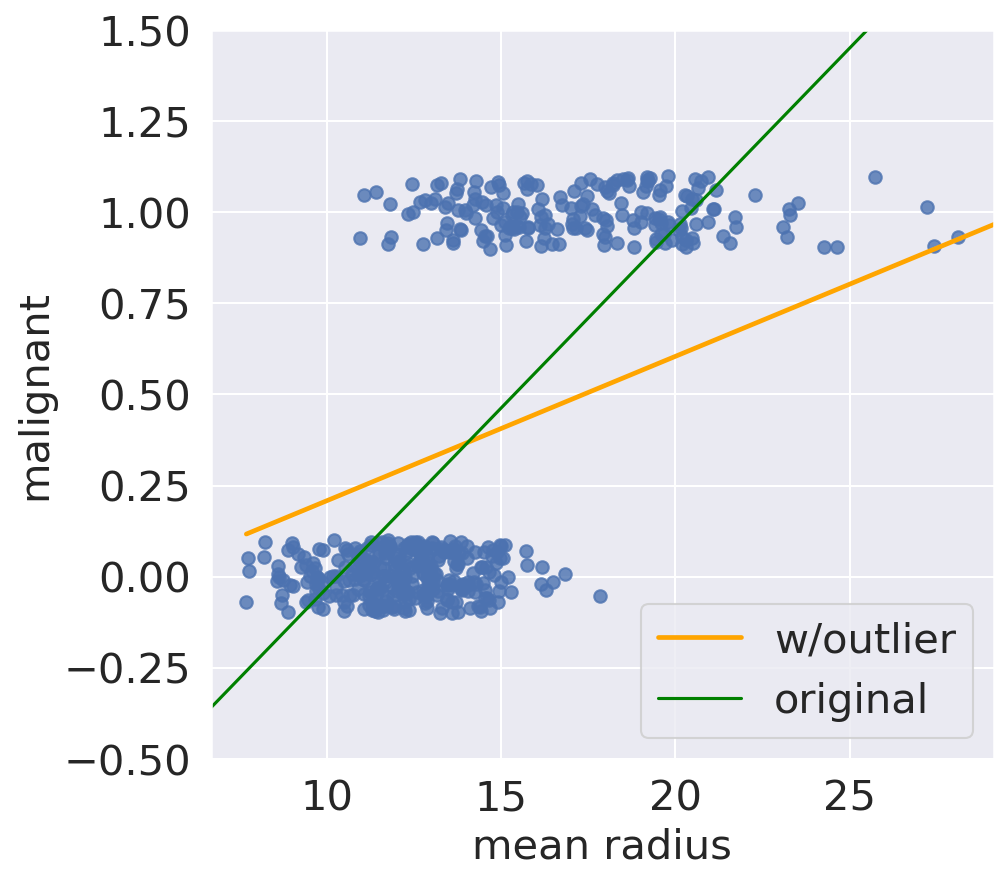

In [14]:
plt.figure(figsize=(6, 6))
sns.regplot(data = data_out, x = "mean radius", y = "malignant", 
              y_jitter = 0.1, 
              ci=False,
              line_kws={'color':'orange', 'label': 'w/outlier'},
           );
x_datapoints = np.array(plt.xlim())
plt.plot(x_datapoints, (x_datapoints)*m + b, color='green', label='original')
plt.ylim((-0.5, 1.5))
plt.xlim((6.67005, 29.13095))
plt.legend()
savefig("outlier")

# Graph of Averages

We need a better model. Let's try and replicate the **graph of averages** for Simple Linear Regression from Data 8 ([textbook](https://inferentialthinking.com/chapters/08/1/Applying_a_Function_to_a_Column.html#example-prediction)), but now for Classification instead.. Recall, we
- binned the $x$ axis.
- took the average $y$ value for each bin on the $x$ axis.

We will do the same thing here, albeit with slightly different code. Here, we will formally partition the $x$-axis into 20 bins.

In [15]:
# partition the training x data
bins = pd.cut(data_tr['mean radius'], 20) # Series of bin labels
data_tr['bin midpoint'] = [(b.left + b.right) / 2 for b in bins]

# then, get the average y per bin
avg_y_by_bin = data_tr.groupby('bin midpoint')['malignant'].mean()
avg_y_by_bin

bin midpoint
8.1915     0.000000
9.2225     0.000000
10.2435    0.000000
11.2645    0.057143
12.2855    0.094595
13.3065    0.200000
14.3275    0.333333
15.3485    0.674419
16.3695    0.750000
17.3900    0.944444
18.4105    1.000000
19.4315    1.000000
20.4525    1.000000
21.4735    1.000000
22.4945    1.000000
23.5155    1.000000
24.5365    1.000000
25.5575    1.000000
27.5995    1.000000
Name: malignant, dtype: float64

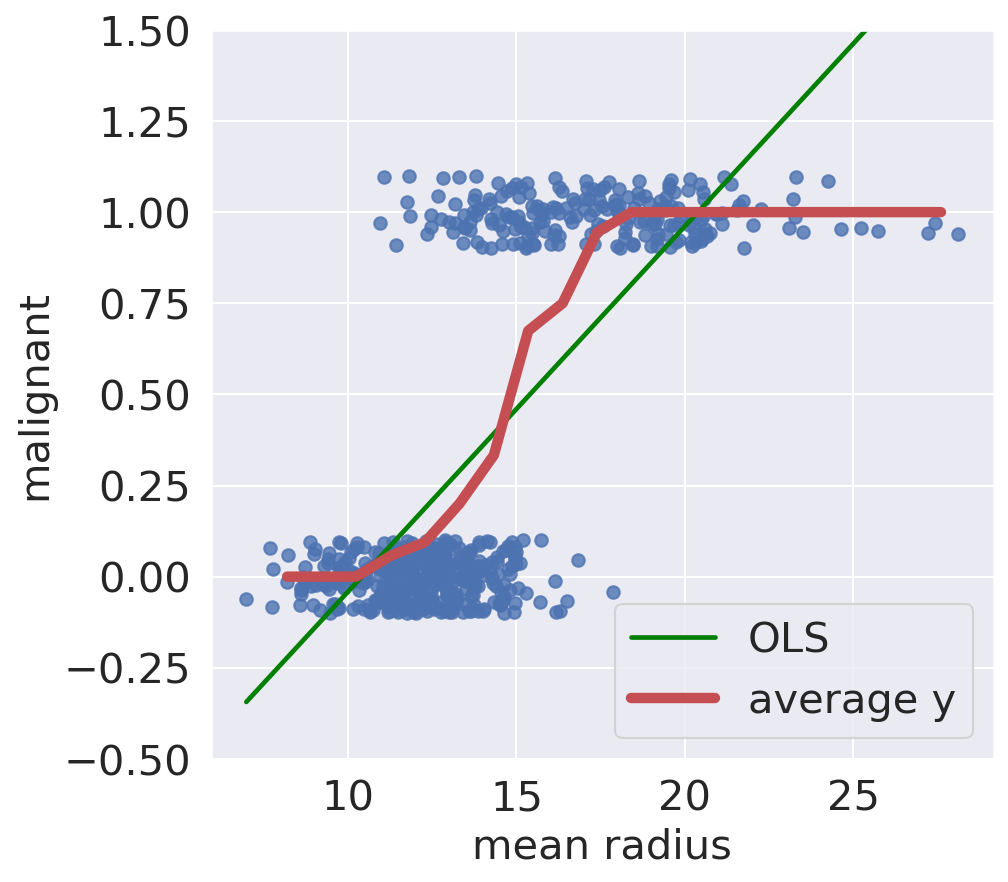

In [16]:
plt.figure(figsize=(6,6))
sns.regplot(data = data, x = "mean radius", y = "malignant", 
              y_jitter = 0.1, 
              ci=False,
              line_kws={'color':'green', 'label': 'OLS'},
           );

plt.plot(avg_y_by_bin, 'r', linewidth = 5, label='average y');
plt.ylim((-0.5, 1.5))
plt.legend()
savefig("graph_of_averages")

It seems like our red graph of averages does a much better job at matching the data than our simple linear regression line.

**Q**: **What is this graph of averages plotting?**

For a given $x$, suppose its bin has the current $y$ as follows, producing the following average $y$:

$$ [0, 0, 1, 1, 1, 1, 0, 0, 0, 0] \rightarrow 0.4 $$

For this bin, the average y value is:
* A number between 0 and 1.
* The frequency of 1’s in the bin.

The average y for a bin is therefore a **probability**!!

$$P(Y = 1 | x) = \frac{\text{# (y == 1) in bin}}{\text{# datapoints in bin
}}$$

**Logistic regression aims to model the probability of an observation belonging to class 1, given some set of features.**

<br/><br/>

Logistic Regression is what we call a generalized linear model.
* Non-linear transformation of a linear model.
* So parameters are still a linear combination of x!

In this notebook, we'll do Step 1 of deriving the logistic model.

## 1. Transform the y-axis non-linearly until the “S curve” looks linear.

First let's rename our variables from earlier so that we simplify some notation.

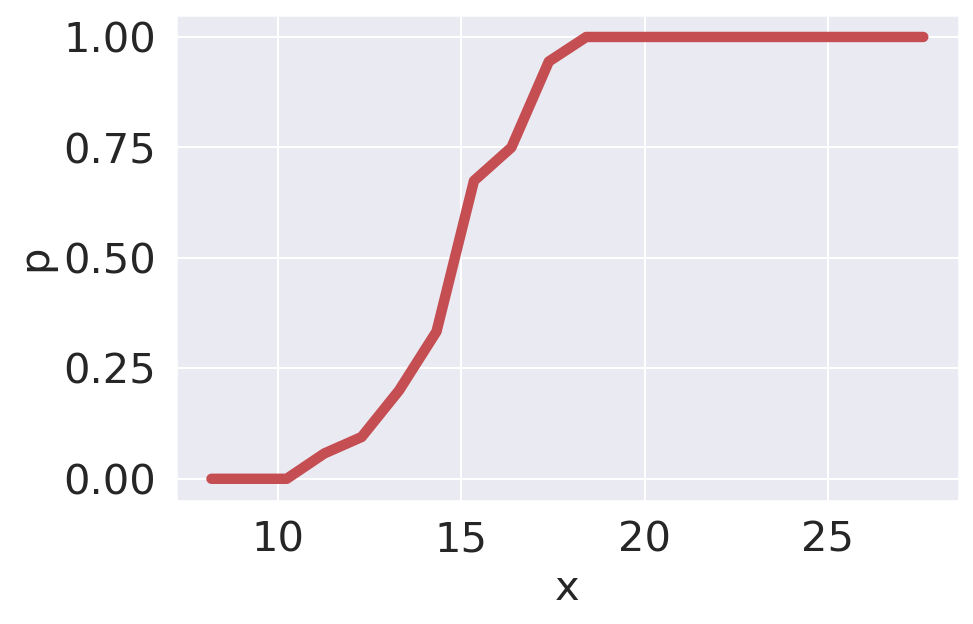

In [17]:
transform_df = pd.DataFrame({"x": avg_y_by_bin.index,
                        "p": avg_y_by_bin.values})

sns.lineplot(data=transform_df, x='x', y='p', color='r', linewidth = 5)
savefig('transform_1')

<br/>

The **odds** of an event are defined as the probability that it happens divided by the probability that it doesn't happen.

If some event happens with probability $p$, then 
<br/>

$$\text{odds}(p) = \frac{p}{1-p}$$

Let's compute the odds of of our probabilities.

If we plot these odds, they look exponential:

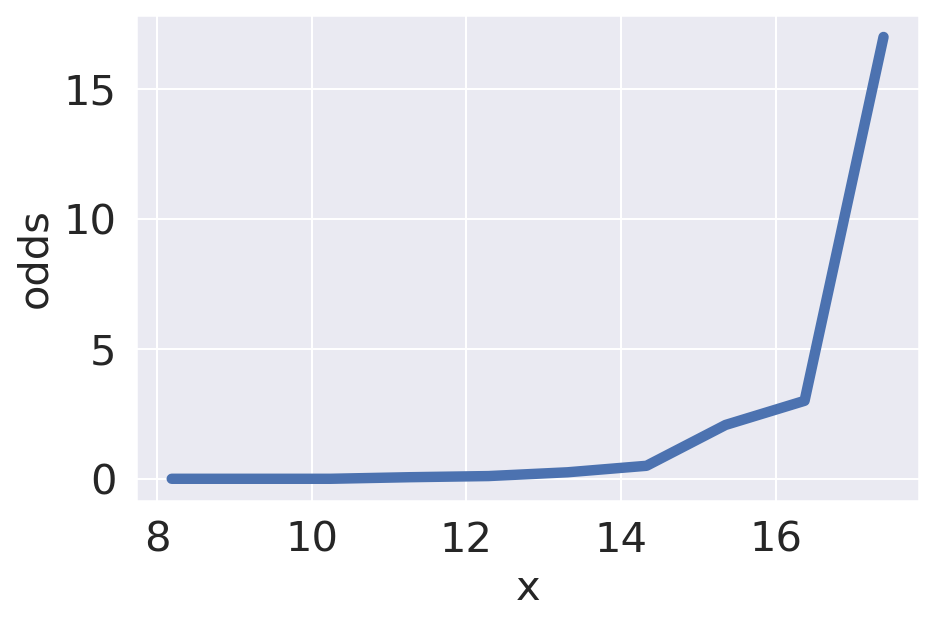

In [18]:
transform_df['odds'] = transform_df['p'] / (1 - transform_df['p'])

sns.lineplot(data=transform_df,
             x='x', y='odds', linewidth = 5)
savefig("transform_2")

But if we take the log of these odds:

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



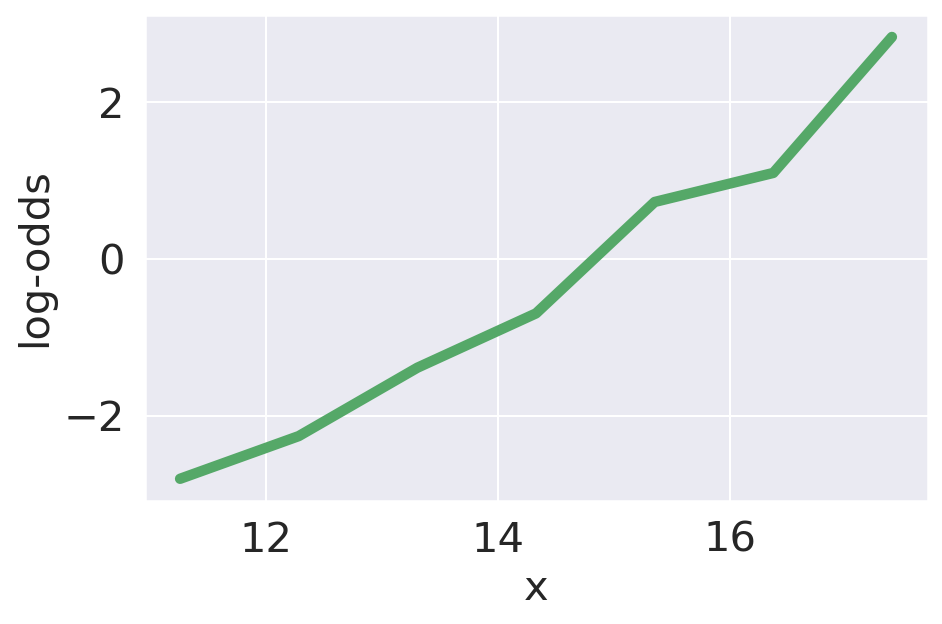

In [19]:
transform_df['log-odds'] = np.log(transform_df['odds'])

sns.lineplot(data=transform_df,
             x='x', y='log-odds',
             color='g', linewidth = 5)
savefig("transform_3")

## 2. Then, use math to invert all transformations.

(This portion is left to the lecture slides.)

We noticed that the **log-odds grows linearly with $x$**. 

In the lecture slides, we formalize what this means, and how this allows us to arrive at the `sigma` function above.

## The Logistic Function

In the slides, we show that our model is

$$P(Y = 1 | x) = \sigma(x^T \theta)$$

where $$\sigma(t) = \frac{1}{1 + e^{-t}}$$

Let's explore the shape of the logistic function, $\sigma$.

In [20]:
# the logistic function
# known as the sigmoid function in ML
def sigma(t):
    return 1 / (1 + np.exp(-t))

In [21]:
theta_0 = -13.8
theta_1 = 0.937

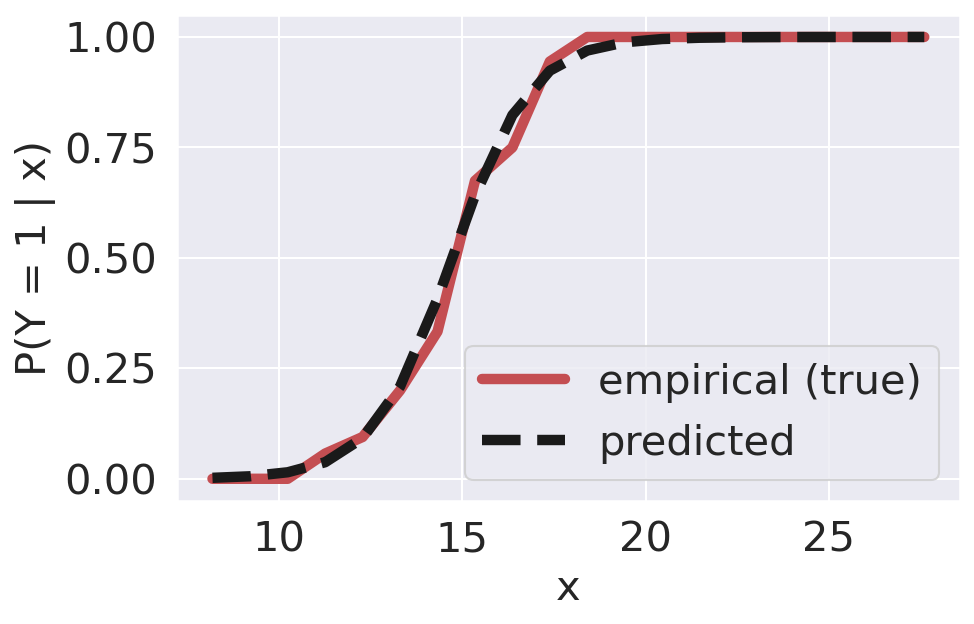

In [22]:
theta_0 = -13.8
theta_1 = 0.937

sns.lineplot(data=transform_df, x='x', y='p', color='r',
             linewidth = 5, label='empirical (true)')
x = transform_df['x']
pred_p = sigma(theta_0 + theta_1 * x)
plt.plot(x, pred_p, 'k--', linewidth = 5, label='predicted');
plt.xlabel('x');
plt.ylabel('P(Y = 1 | x)')
plt.legend()
savefig("overlay")

We'll explain how we found the optimal parameter fit by the end of lecture, but for now hopefully you're convinced that the S-curve is actually a logistic function.

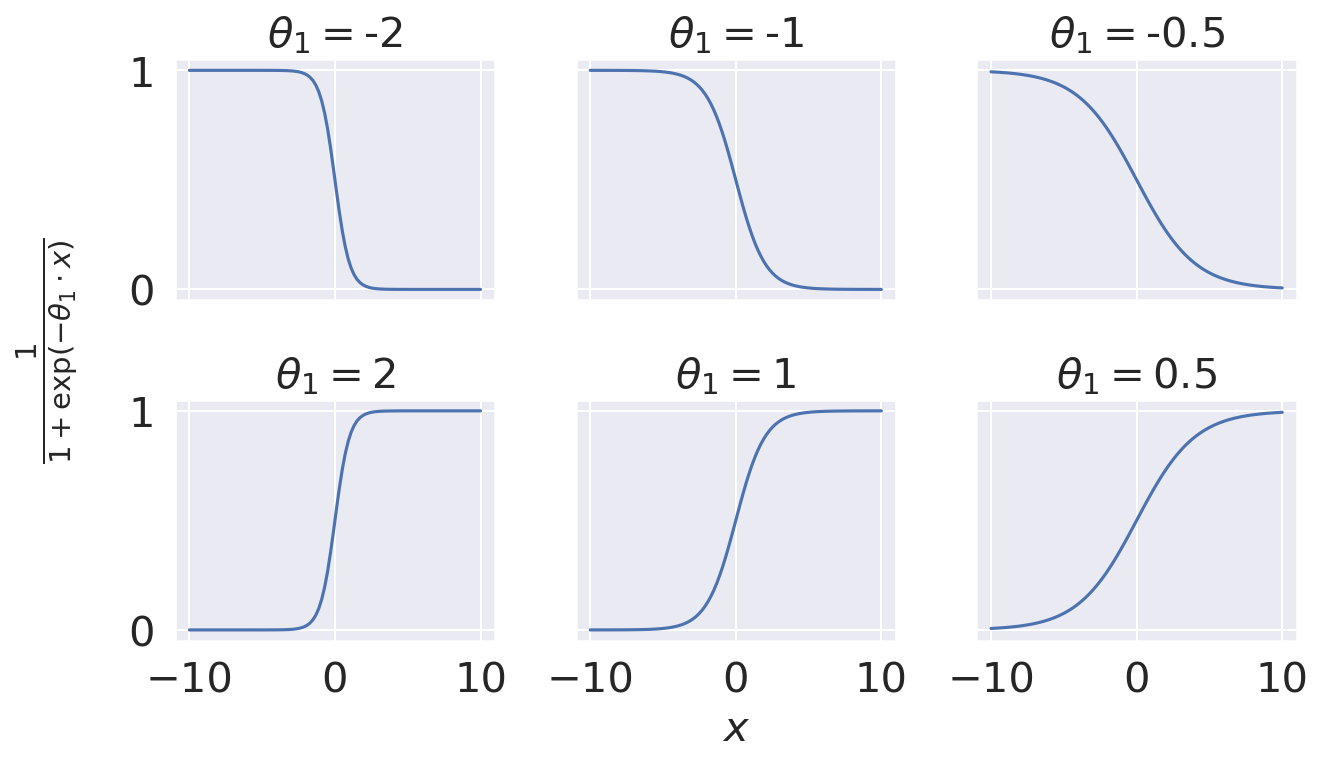

In [23]:
def flatten(li): 
    return [item for sub in li for item in sub]

bs = [-2, -1, -0.5, 2, 1, 0.5]
xs = np.linspace(-10, 10, 100)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
for ax, b in zip(flatten(axes), bs):
    ys = sigma(xs * b)
    ax.plot(xs, ys)
    ax.set_title(r'$ \theta_1 = $' + str(b))

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False,
                left=False, right=False)
plt.grid(False)
plt.xlabel('$x$')
plt.ylabel(r'$ \frac{1}{1+\exp(-\theta_1 \cdot x)} $')
plt.tight_layout()
savefig('sigmoids.png')

Let's explore the shape of $\sigma(\theta_0 + \theta_1x)$, for different values of $\theta_0, \theta_1$. There's quite a bit going on here, so let's use `plotly`.

## Logistic Regression with Squared Loss

We've chosen a model. It's now time to choose a loss function. Why not squared loss?

In [24]:
def mse_loss_train_nobias(theta):
    x = data_tr['mean radius']
    y_obs = data_tr['malignant']
    y_hat = sigma(x * theta)
    return np.mean((y_hat - y_obs) ** 2)  

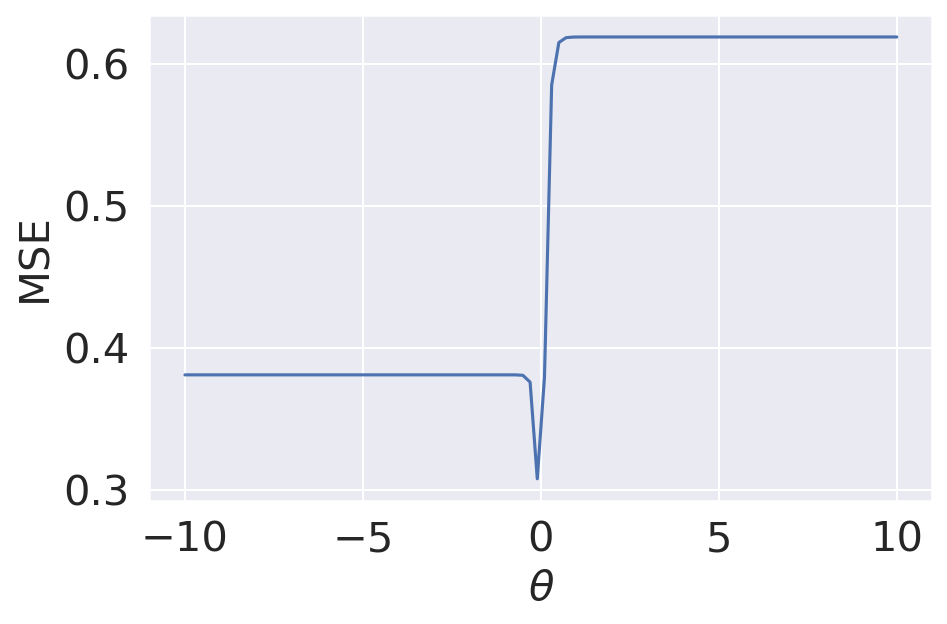

In [25]:
thetas = np.linspace(-10, 10, 100)
plt.plot(thetas, [mse_loss_train_nobias(theta) for theta in thetas])
plt.ylabel('MSE')
plt.xlabel(r'$\theta$');

<br/><br/>

What????

## Toy Dataset: L2 Loss

Consider this manufactured dataset.

In [26]:
toy_df = pd.DataFrame({
        "x": [-4, -2, -0.5, 1, 3, 5],
        "y": [0, 0, 1, 0, 1, 1]
        #"x": [-9.5, -5.8, -4.0, 8.7, 12.0],
        #"y": [1, 0, 0, 1, 0]
})
toy_df.sort_values("x")

,x,y
0,-4.0,0
1,-2.0,0
2,-0.5,1
3,1.0,0
4,3.0,1
5,5.0,1


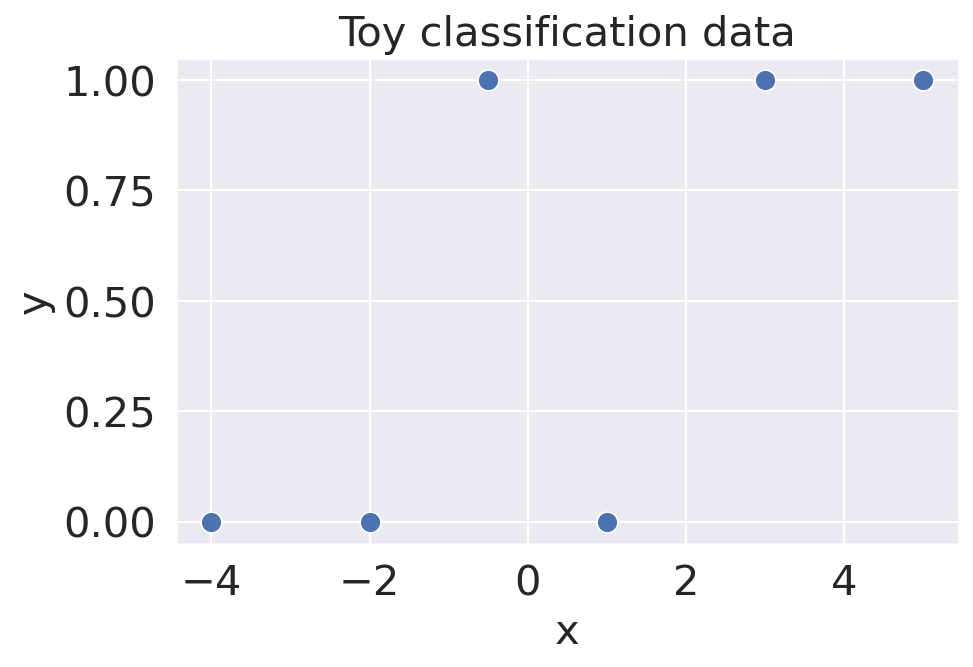

In [27]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100)
plt.title("Toy classification data")
savefig("toy")

Let's plot the loss surface for this toy data using squared loss with the model $\hat{p} = \sigma(\theta x)$. We don't include an intercept term, so $\theta$ and $x$ are both scalars.

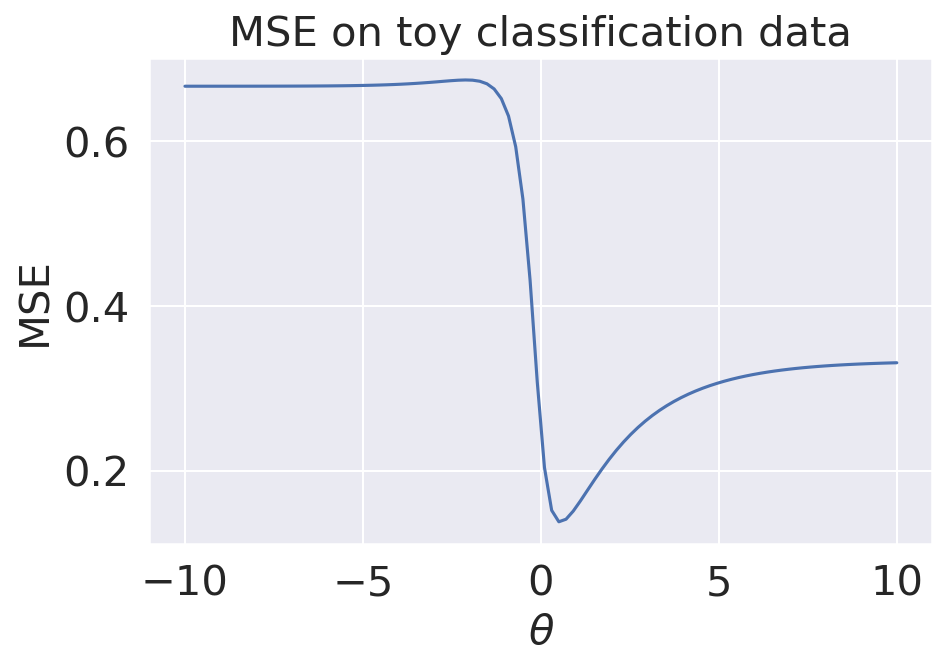

In [28]:
def mse_loss_toy_nobias(theta):
    p_hat = sigma(toy_df['x'] * theta)
    return np.mean((toy_df['y'] - p_hat)**2)

thetas = np.linspace(-10, 10, 100)
plt.plot(thetas, [mse_loss_toy_nobias(theta) for theta in thetas])
plt.title("MSE on toy classification data");
plt.xlabel(r'$\theta$')
plt.ylabel('MSE')
savefig("toy_mse")

This loss surface is not convex! Depending on where we start our optimization search, we'll end up with different results. Let's explore with `scipy.optimize.minimize`.

In [29]:
best_theta = minimize(mse_loss_toy_nobias, x0 = 0)["x"][0]
best_theta

0.5446601825581691

Remember, our 1-D model with no intercept is $\hat{p} = \sigma(\theta x)$.

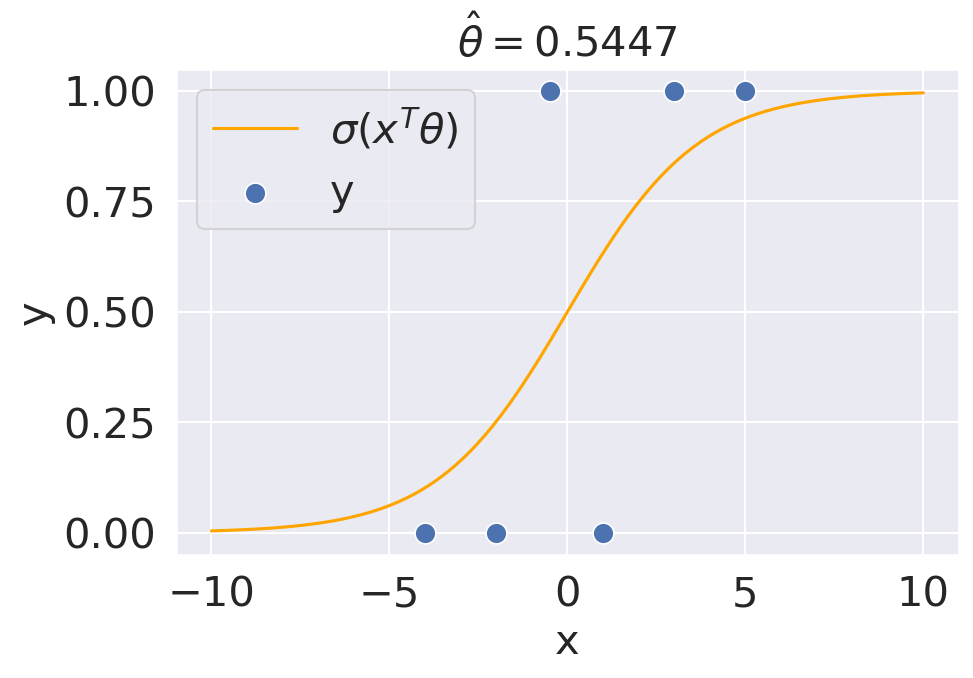

In [30]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, label='y')
xs = np.linspace(-10, 10, 100)
plt.plot(xs, sigma(xs * best_theta), color='orange', label=r'$\sigma(x^T \theta)$')
plt.xlabel('x')
plt.legend()
plt.title(r'$\hat{\theta} = $' + f"{best_theta:.4}")
savefig("toy_best_mse_1")

<br/>
Let's try another starting point for minimizing theta.

In [31]:
best_theta_2 = minimize(mse_loss_toy_nobias, x0 = -5)["x"][0]
best_theta_2

-10.343653061026611

Uhhh, looks like the optimizer got stuck.

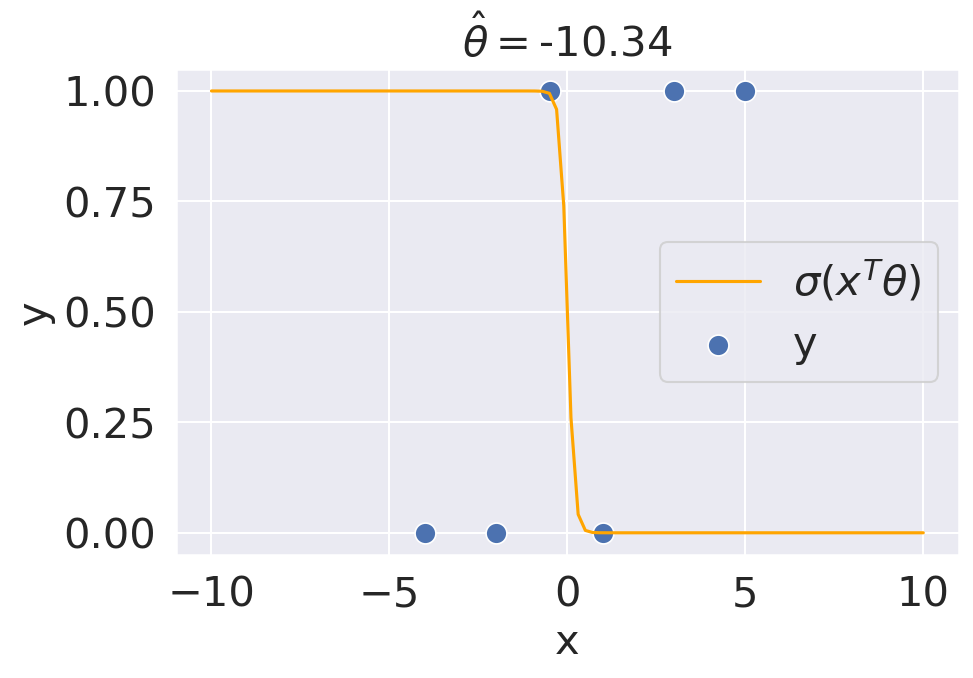

In [32]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, label='y')
xs = np.linspace(-10, 10, 100)
plt.plot(xs, sigma(xs * best_theta_2), color='orange', label=r'$\sigma(x^T \theta)$')
plt.xlabel('x')
plt.legend()
plt.title(r'$\hat{\theta} = $' + f"{best_theta_2:.4}")
savefig("toy_best_mse_2")

Not only is it not convex, leading to the weird issues above, but squared loss just isn't well-suited for a probability task. Since $\hat{p}_i$ is between 0 and 1, and $y_i$ is either 0 or 1, the squared loss for a single point $(y_i - \hat{p}_i)^2$ is bounded between 0 and 1.

What this means in practice: even if our prediction is terrible, the squared loss is never that large.

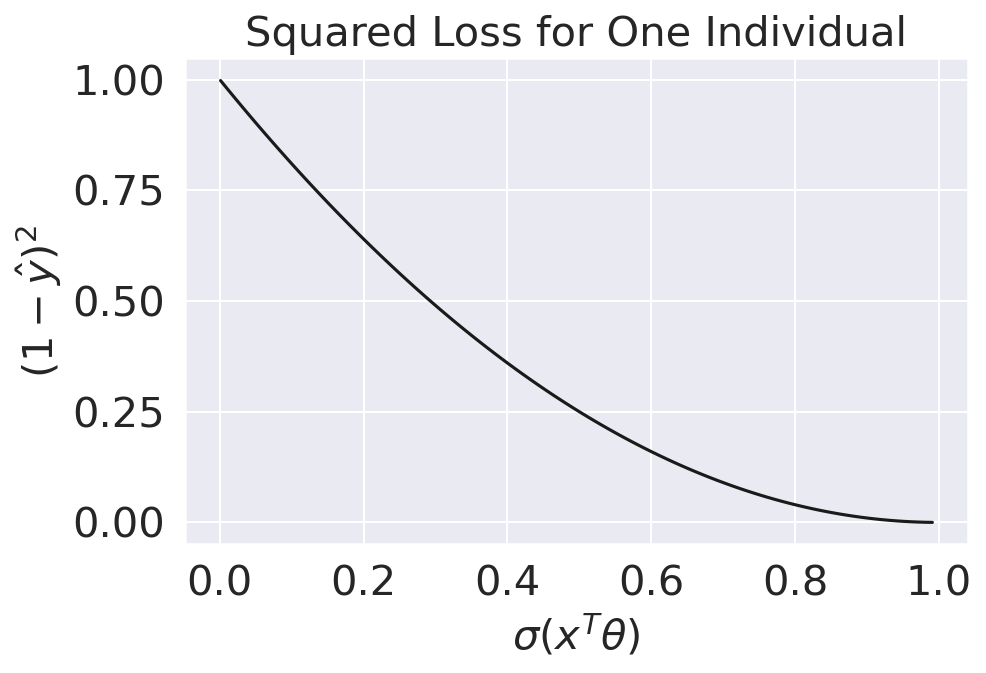

In [33]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = (1 - p_hat)**2
plt.plot(p_hat, loss, color='k')
plt.xlabel(r'$\sigma({x^T \theta})$')
plt.ylabel(r'$(1 - \hat{y})^2$')
plt.title('Squared Loss for One Individual');
savefig("mse_individual")

## Motivating Cross-Entropy Loss

Let's look at a new loss, called the log loss, for when our true observation is 1.

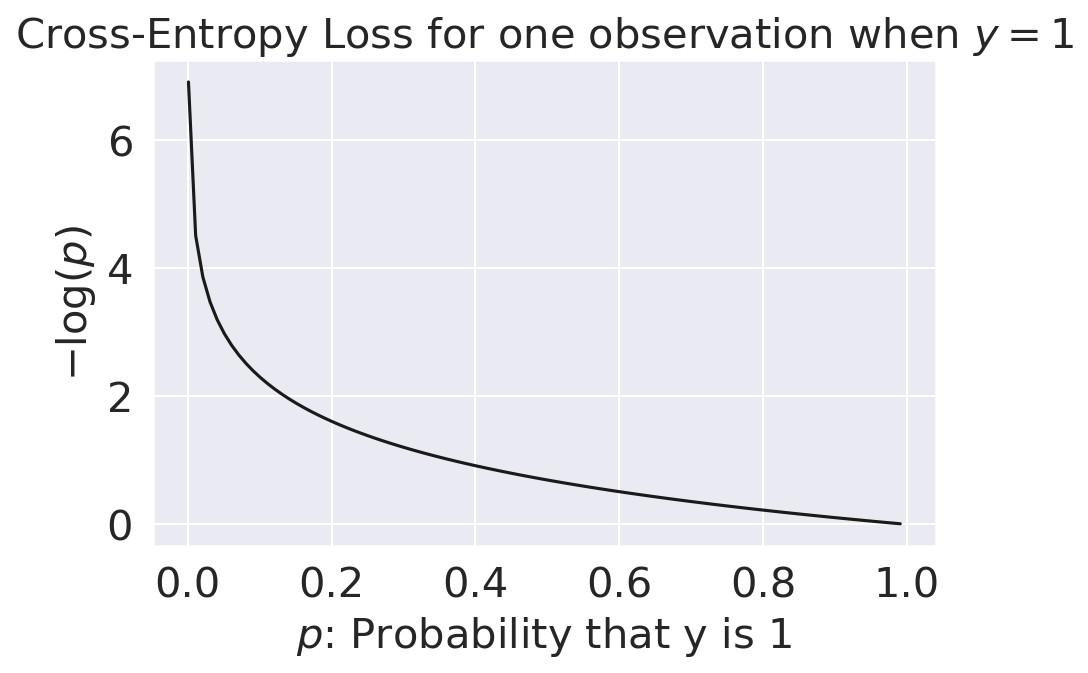

In [34]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$p$: Probability that y is 1')
plt.ylabel('$-\log(p)$')
plt.title('Cross-Entropy Loss for one observation when $y = 1$');
savefig("entropy_y1")

We can see that this penalizes wrong predictions far more than squared loss does.

How to read this plot: Suppose the observation we're trying to predict is actually in class 1. If our model gives an 80% chance of being in class 1, the loss is relatively small (around 0.25). 

If we give only a 40% of being in class 1, the loss is larger (around 1).

If we give only a 5% chance of being in class 1, the loss is 3.

And if we give a 0% chance of being in class 1, the loss is infinite.

What about when the true observation is 0?

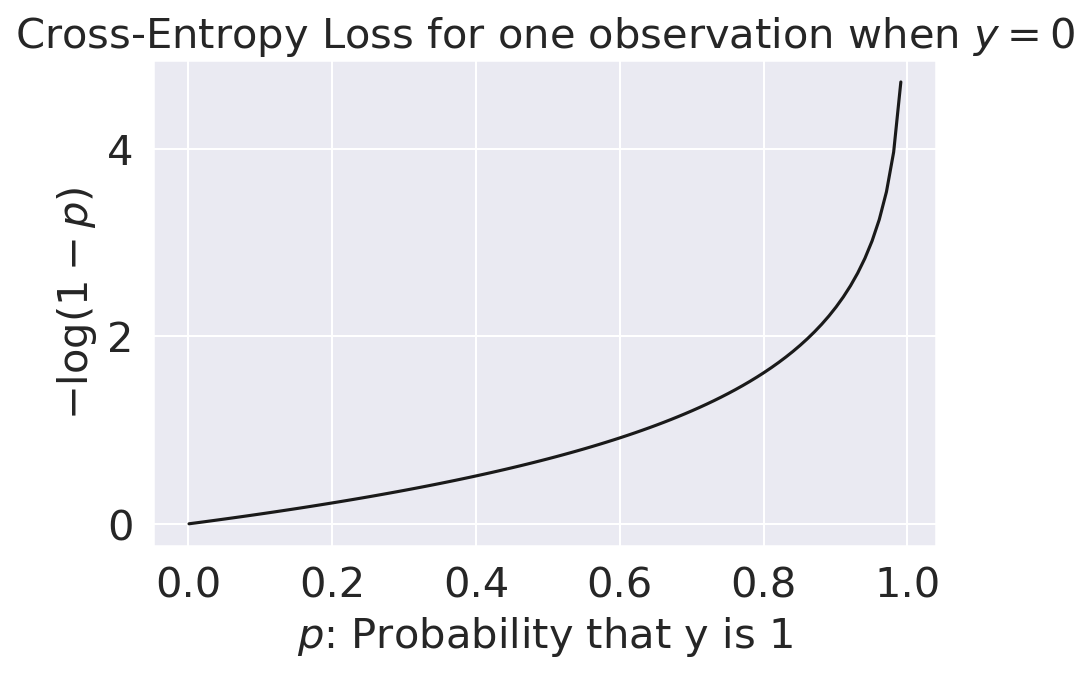

In [35]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(1 - p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$p$: Probability that y is 1')
plt.ylabel('$-\log(1 - p)$')
plt.title('Cross-Entropy Loss for one observation when $y = 0$');
savefig("entropy_y0")

Much of the formal derivation is in the slides. But the equation for cross-entropy loss for a single observation is

$$\textrm{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y})$$

For us, since $\hat{y} = \sigma(x^T \theta)$, the expression for average cross-entropy loss is

$$R(\theta) = -\frac{1}{n} \sum_{i = 1}^n \big(y_i \log (\sigma(\mathbb{X}_i^T \theta)) + (1 - y_i) \log (1 - \sigma(\mathbb{X}_i^T \theta))\big)$$

Let's look at the loss surface for average cross-entropy loss, on our toy data from before.

In [36]:
def cross_entropy(y, phat):
    return - y * np.log(phat) - (1 - y) * np.log(1 - phat)

In [37]:
def mce_loss_toy_nobias(theta):
    p_hat = sigma(toy_df['x'] * theta)
    return np.mean(cross_entropy(toy_df['y'], p_hat))

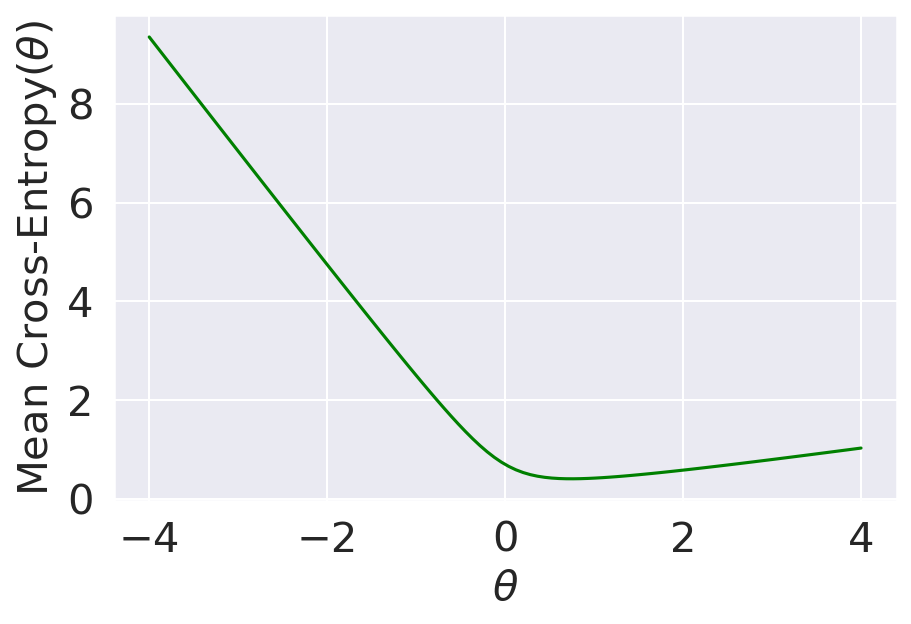

In [38]:
thetas = np.linspace(-4, 4, 100)
plt.plot(thetas, [mce_loss_toy_nobias(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy($\theta$)')
plt.xlabel(r'$\theta$');
savefig("toy_mce")